In [426]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [427]:
TRAY_HSV_LOWER_BOUND = (85, 40, 20)
TRAY_HSV_UPPER_BOUND = (130, 255, 255)

BREAD_HSV_LOWER_BOUND = (10, 50, 100)
BREAD_HSV_UPPER_BOUND = (40, 255, 255)

TRAY_BOX_PIX = (
    250,
    20,
    630,
    300,
)  # (x1, y1, x2, y2) coordinates of the tray box in the image

In [428]:
first_img_path = "/home/parth/snaak/data/SCH_images_041125/cheese_check_1/image_20250411-150254.png"
second_img_path = "/home/parth/snaak/data/SCH_images_041125/cheese_check_3/image_20250411-150547.png"

first_img = cv2.imread(first_img_path)
second_img = cv2.imread(second_img_path)

# resize the images to 840x480
first_img = cv2.resize(first_img, (840, 480))
second_img = cv2.resize(second_img, (840, 480))

In [429]:
# Crop the tray box from the first ham image
first_crop = first_img[TRAY_BOX_PIX[1]:TRAY_BOX_PIX[3], TRAY_BOX_PIX[0]:TRAY_BOX_PIX[2]]
second_crop = second_img[TRAY_BOX_PIX[1]:TRAY_BOX_PIX[3], TRAY_BOX_PIX[0]:TRAY_BOX_PIX[2]]

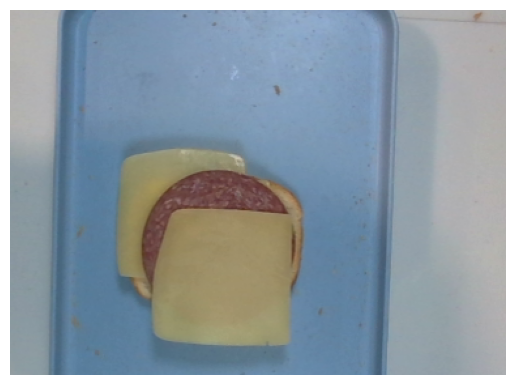

In [430]:
plt.imshow(cv2.cvtColor(first_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

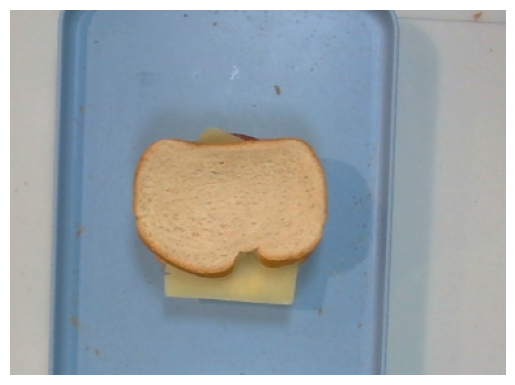

In [431]:
plt.imshow(cv2.cvtColor(second_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

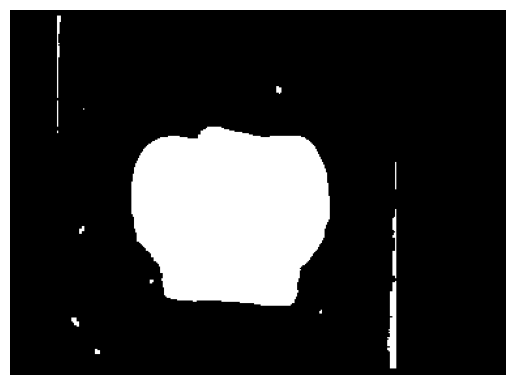

In [432]:
# Segment tray from the second image using tray HSV values
# Convert the image to HSV color space
second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
tray_hsv_lower_bound = np.array(TRAY_HSV_LOWER_BOUND, dtype=np.uint8)
tray_hsv_upper_bound = np.array(TRAY_HSV_UPPER_BOUND, dtype=np.uint8)
tray_mask = cv2.inRange(second_hsv, tray_hsv_lower_bound, tray_hsv_upper_bound)

# Invert the tray mask
tray_mask_inv = cv2.bitwise_not(tray_mask)

# Find the bounding box of the tray
contours, _ = cv2.findContours(tray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    tray_x, tray_y, tray_w, tray_h = cv2.boundingRect(largest_contour)


# Black out everything outside the tray box coordinate in tray_mask_inv
tray_mask_inv[0:tray_y+5, :] = 0
tray_mask_inv[tray_y+tray_h-5:, :] = 0
tray_mask_inv[:, 0:tray_x+5] = 0
tray_mask_inv[:, tray_x+tray_w-5:] = 0

plt.imshow(tray_mask_inv, cmap='gray')
plt.axis('off')
plt.show()

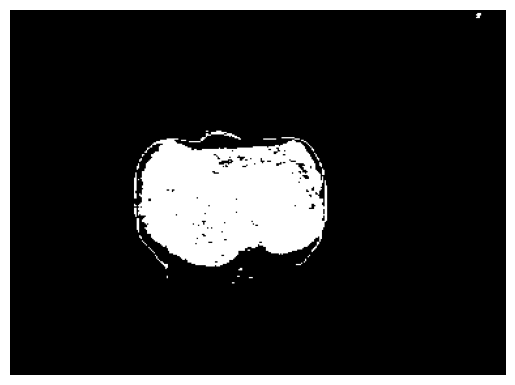

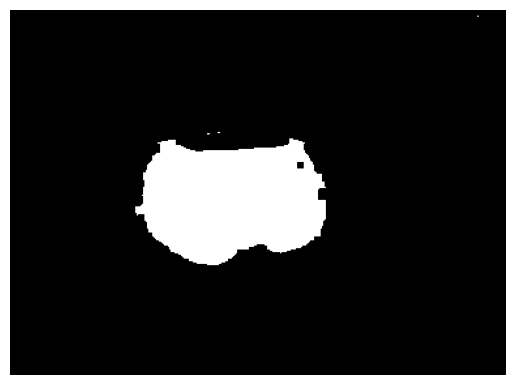

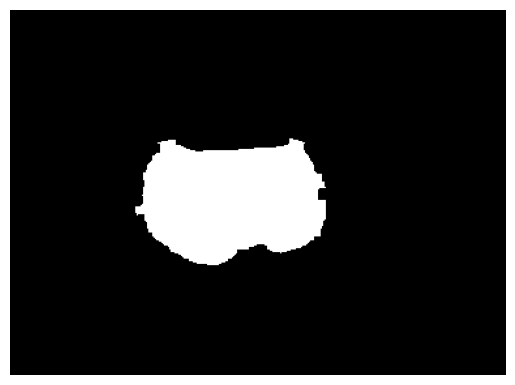

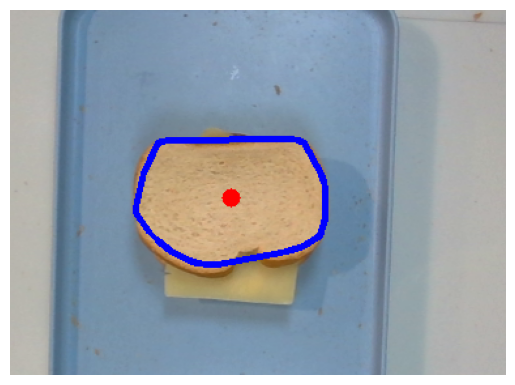

In [433]:
BREAD_HSV_LOWER_BOUND_STRICT = (10, 60, 100)
BREAD_HSV_UPPER_BOUND_STRICT = (20, 110, 220)

second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
bread_hsv_lower_bound = np.array(BREAD_HSV_LOWER_BOUND_STRICT, dtype=np.uint8)
bread_hsv_upper_bound = np.array(BREAD_HSV_UPPER_BOUND_STRICT, dtype=np.uint8)
bread_mask = cv2.inRange(second_hsv, bread_hsv_lower_bound, bread_hsv_upper_bound)

plt.imshow(bread_mask, cmap='gray')
plt.axis('off')
plt.show()

# Gaussian blur the bread mask
# bread_mask = cv2.GaussianBlur(bread_mask, (5, 5), 0)

# Erode the bread mask to remove noise
bread_mask = cv2.dilate(bread_mask, None, iterations=1)
bread_mask = cv2.erode(bread_mask, None, iterations=2)
# Dilate the bread mask to fill in gaps

plt.imshow(bread_mask, cmap='gray')
plt.axis('off')
plt.show()

# Select only the largest contour and blacken out the rest
contours, _ = cv2.findContours(bread_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:    
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    bread_mask = np.zeros_like(bread_mask)
    cv2.drawContours(bread_mask, [largest_contour], -1, 255, -1)

# Apply closing to fill in small holes
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
bread_mask = cv2.morphologyEx(bread_mask, cv2.MORPH_CLOSE, kernel)

plt.imshow(bread_mask, cmap='gray')
plt.axis('off')
plt.show()

plot_image = second_crop.copy()

# Plot the contours on the original image
contours, _ = cv2.findContours(bread_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)          
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    # cv2.drawContours(second_crop, [largest_contour], -1, (0, 255, 0), 3)

    # Find convex hull
    hull = cv2.convexHull(largest_contour)
    cv2.drawContours(plot_image, [hull], -1, (255, 0, 0), 3)

    # Find the center of the convex hull
    M = cv2.moments(hull)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0
    # Draw the center
    cv2.circle(plot_image, (cX, cY), 7, (0, 0, 255), -1)

plt.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

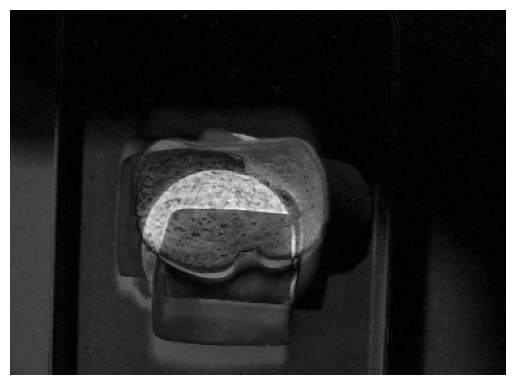

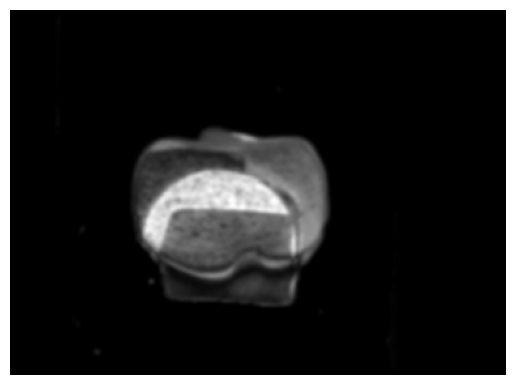

In [434]:
# Segment tray from the second image using tray HSV values
# Convert the image to HSV color space
second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
tray_hsv_lower_bound = np.array(TRAY_HSV_LOWER_BOUND, dtype=np.uint8)
tray_hsv_upper_bound = np.array(TRAY_HSV_UPPER_BOUND, dtype=np.uint8)
tray_mask = cv2.inRange(second_hsv, tray_hsv_lower_bound, tray_hsv_upper_bound)

# Invert the tray mask
tray_mask_inv = cv2.bitwise_not(tray_mask)

# Find the bounding box of the tray
contours, _ = cv2.findContours(tray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    tray_x, tray_y, tray_w, tray_h = cv2.boundingRect(largest_contour)


# Black out everything outside the tray box coordinate in tray_mask_inv
tray_mask_inv[0:tray_y+5, :] = 0
tray_mask_inv[tray_y+tray_h-5:, :] = 0
tray_mask_inv[:, 0:tray_x+5] = 0
tray_mask_inv[:, tray_x+tray_w-5:] = 0

# Calculate the difference between the two images
diff = cv2.absdiff(first_crop, second_crop)
gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_diff, cmap='gray')
plt.axis('off')
plt.show()


# And operate the difference image with bread mask and tray mask
gray_diff = cv2.bitwise_and(gray_diff, gray_diff, mask=tray_mask_inv)


# Remove noise from the difference image
gray_diff = cv2.GaussianBlur(gray_diff, (7, 7), 0)

plt.imshow(gray_diff, cmap='gray')
plt.axis('off')
plt.show()
